In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fnmatch

In [2]:
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [3]:
from trainlib.ConfigFileHandler import ConfigFileHandler
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.ConfigFileUtils import ConfigFileUtils

Welcome to JupyROOT 6.10/09


Using TensorFlow backend.


In [4]:
bin_dir = {"Untagged": 0,
            "VBF1j": 1,
            "VBF2j": 2,
            "VHlept": 3,
            "VHhadr": 4,
            "ttHlept": 5,
            "ttHhadr": 6,
            "VHMET": 7}

In [5]:
campaign_workspace = "/data_CMS/cms/wind/"
campaign_names = ["180409_MC_weighting_Adam", "180409_no_MC_weights_Adam", "180409_no_MC_weights_Adam_smallbatch", "180406_MC_weighting_Adam", "180406_no_MC_weighting_Adam", "180406_MC_weighting_SGD", "180406_no_MC_weighting_SGD", "180408_no_weights_oldtraining"]

In [8]:
def make_comparison_plot(campaign_workspace, campaign_names, identifier):
    df = pd.DataFrame()

    for campaign_name in campaign_names:
        campaign_dir = campaign_workspace + campaign_name + "/"
    
        for folder, subs, files in os.walk(campaign_dir):
            if fnmatch.fnmatch(folder, identifier):
                values = {}
            
                punzi_file = folder + "/Mor18_punzi_comp.conf"
            
                try:                
                    # try to read the punzi values
                    conf = ConfigFileHandler()
                    conf.load_configuration(punzi_file)
                    
                    # load the Punzi values for each category
                    for category, bin_number in bin_dir.iteritems():
                        values[category] = [float(conf.get_field("Punzi", category))]
            
                    benchmark_value = values['VBF1j'][0] + values['VBF2j'][0] + values['VHlept'][0] + values['VHhadr'][0] + values['ttHlept'][0] + values['ttHhadr'][0] + values['VHMET'][0] - 7
            
                    values["campaign"] = folder.replace(campaign_workspace, '') + ' (' + str(benchmark_value) + ')'
                    values["benchmark_value"] = benchmark_value
            
                    df = df.append(pd.DataFrame.from_dict(values))
                except (KeyError, IOError):
                    print(punzi_file + " does not exist")
                    
    df = df.sort_values('benchmark_value', ascending = False)
                
    sorted_datacols = sorted(bin_dir.items(), key = lambda x: x[1])
    sorted_datacol_names = [x[0] for x in sorted_datacols]
    
    punzi_data = df[sorted_datacol_names].as_matrix()
    punzi_data = np.transpose(punzi_data)
    
    inparam_labels = df['campaign'].as_matrix()
    
    plt.figure(figsize = (15, 10))
    plt.imshow(punzi_data, interpolation = 'none', cmap = 'RdYlGn', aspect = 0.6, vmin = 0.8, vmax = 1.2)
    plt.colorbar()
    plt.yticks(range(len(bin_dir)), sorted_datacol_names)
    plt.xticks(range(len(df)), inparam_labels, rotation = 'vertical')
    plt.tight_layout()
    plt.title("Punzi purity ratio")
    #plt.savefig(statistics_dir + "punzi_input_sweep.pdf")
    #plt.show()
    
    return plt

In [91]:
%%capture
plot_09 = make_comparison_plot(campaign_workspace, ["180409_no_MC_weights_Adam_smallbatch"], "*comp_prior*")

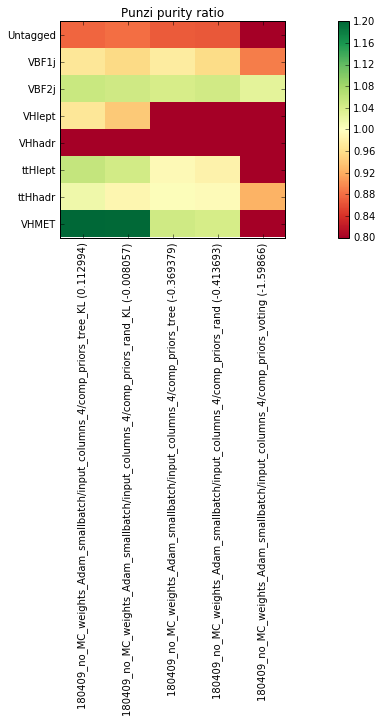

In [92]:
plot_09.show()

In [62]:
%%capture
best_plot =  make_comparison_plot(campaign_workspace, ["180408_no_weights_oldtraining"], "*comp*")

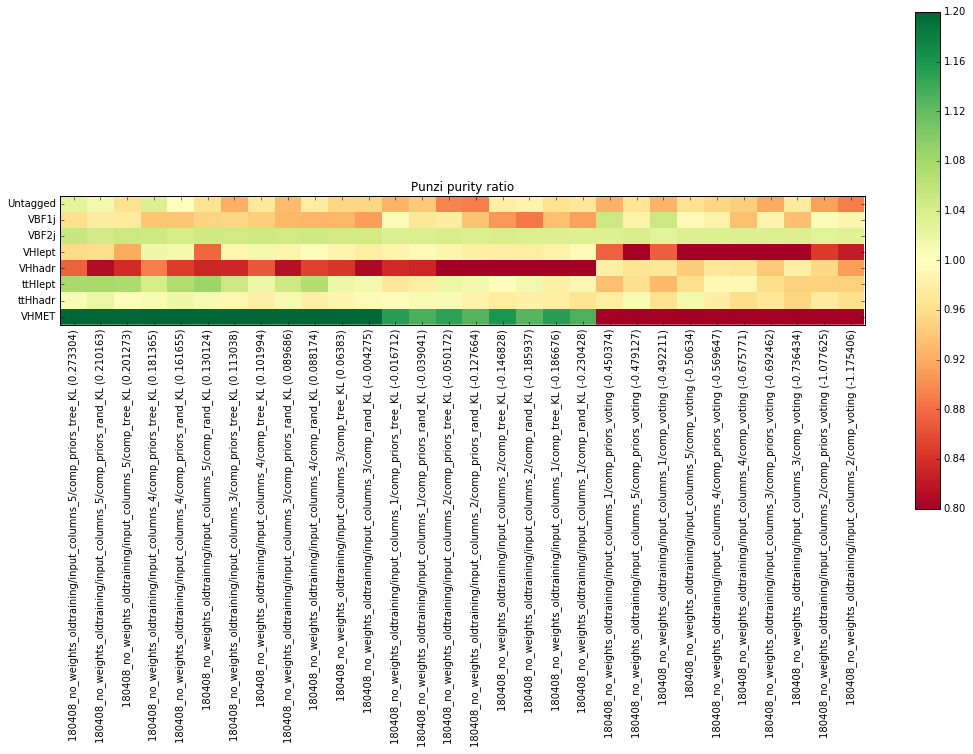

In [63]:
best_plot.show()

In [81]:
%%capture
plot_10 = make_comparison_plot(campaign_workspace, ["180410_class_weights_RMSprop_smallbatch",
                                                    "180410_no_weights_RMSprop_smallbatch",
                                                    "180410_class_weights_Adam_largebatch",
                                                    "180410_class_weights_Adam_smallbatch"], "*comp_prior*")

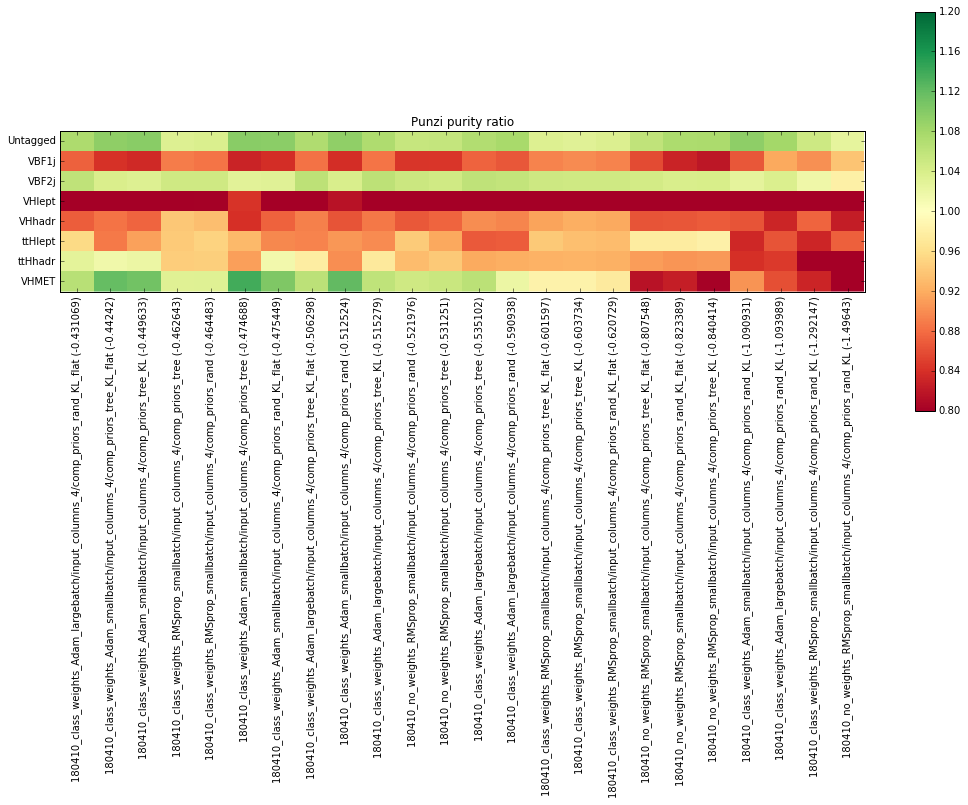

In [82]:
plot_10.show()

In [88]:
%%capture
plot_11 = make_comparison_plot(campaign_workspace, ["180411_class_weights_Adam_optimized_softjets", "Manual"], "*comp_prior*")

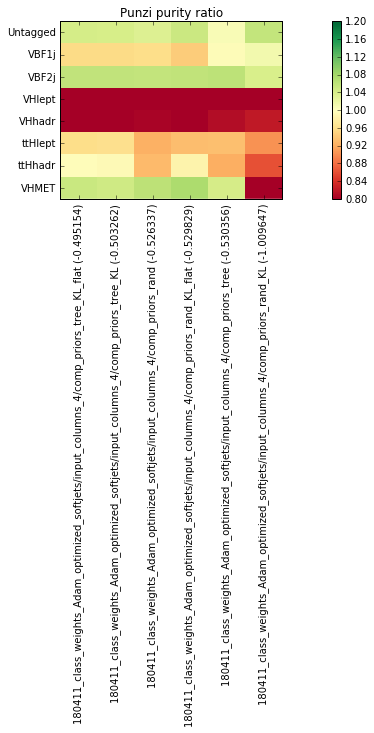

In [89]:
plot_11.show()

In [86]:
plot_12 = make_comparison_plot(campaign_workspace, ["180412_oldtraining_reanalysis", "Manual"], "*comp_prior*")

attempting to load configuration file from /data_CMS/cms/wind/180412_oldtraining_reanalysis/input_columns_4/comp_priors_tree/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180412_oldtraining_reanalysis/input_columns_4/comp_priors_tree_KL/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180412_oldtraining_reanalysis/input_columns_4/comp_priors_tree_KL_flat/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180412_oldtraining_reanalysis/input_columns_4/comp_priors_rand/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180412_oldtraining_reanalysis/input_columns_4/comp_priors_rand_KL/Mor18_punzi_comp.conf
attempting to load configuration file from /data_CMS/cms/wind/180412_oldtraining_reanalysis/input_columns_4/comp_priors_rand_KL_flat/Mor18_punzi_comp.conf


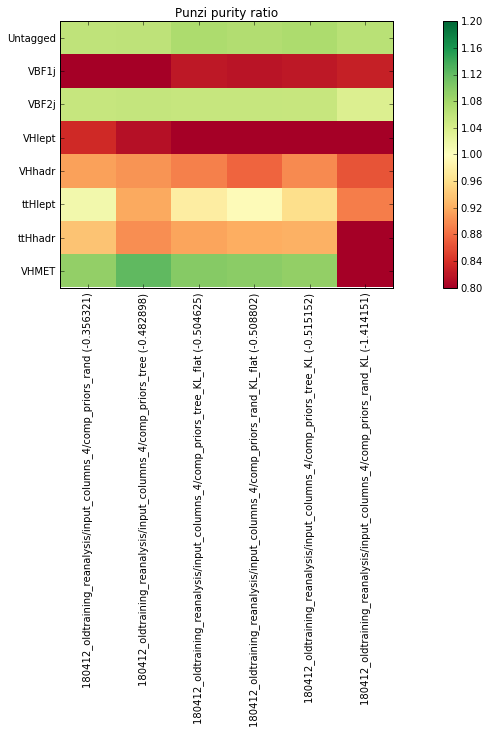

In [87]:
plot_12.show()

In [35]:
%%capture
globalplot = make_comparison_plot(campaign_workspace, campaign_names, "*comp_prior*")

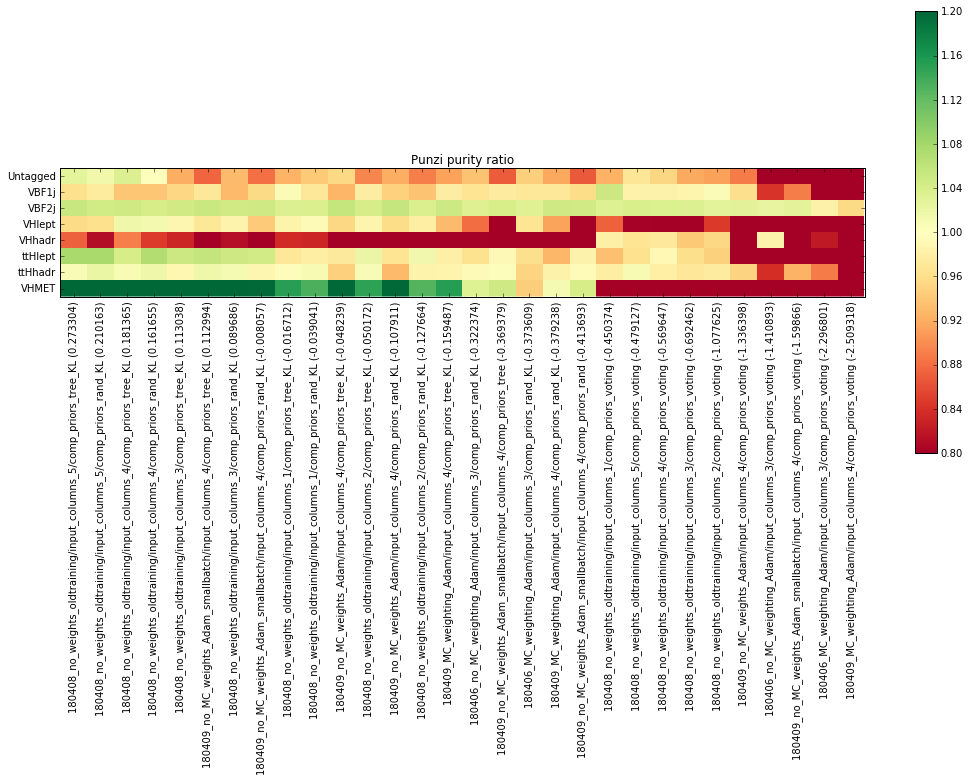

In [98]:
globalplot.show()